# Integration in higher dimensions

NB library functions:

`from scipy.integrate import dblquad, tplquad, nquad`

#### Example: 2D integrals over a rectangular domain

$$
I[f] = \int_0^{1}\!\int_0^{1}\! f(x, y)\, dy\, dx \;.
$$

Use a Gauss-Legendre quadrature (weight function $=1$) for both $x$ and $y$:

$$
Q[f] = \sum_{j=0}^{m} \sum_{k=0}^{n} f(x_j, y_k)\, w_j^{(x)} \, w_k^{(y)}
$$

#### Example: 2D integrals over a triangular domain

$$
\begin{aligned}
I[f] &= \int_0^1 \! \int_0^{\color{red}{x}} \! f(x, y) \, dy \, dx \qquad\text{change variables } y = tx \\
     &= \int_0^1 \! \int_0^{\color{red}{1}} \! f(x, t\color{red}{x})\, \color{red}{x}\, dt \, dx \\
     &= \int_0^1\! \left(\int_0^1\!f(x, tx)\, dt \right) x\,dx
\end{aligned}
$$


The weight in $t$ is still uniform, so use the Gauss-Legendgre quadrature in $t$. For $x$, http://dlmf.nist.gov/18.3 suggests using the Jacobi quadrature with $\alpha = 0$ and $\beta = 1$, after a change of variables $x = (1 + \xi) / 2$ with $\xi \in (-1, 1)$.

An issue with these sorts of tricks is that they do not easily generalize for non-trivial boundaries.

# Monte Carlo integration

## I. Buffon's needle: compute the volume of a unit sphere 

The area of a unit circle $\mathcal{C}$ can be computed as follows:

* Consider a unit square $\mathcal{D}$. Generate $N$ pairs of random numbers with uniform distribution on $\mathcal{D}$.
* For each pair $j$, check if it's inside the circle, calculate the total number of points which are inside, $N_\mathrm{inside}$.
* The estimate for the area of the circle, $\Omega_\mathcal{C}$ is given by

$$
\frac{\Omega_\mathcal{C}}{\Omega_\mathcal{D}} \approx \frac{N_\mathrm{inside}}{N}
$$

and $\Omega_\mathcal{C}$ converges to the true area of the circle in the limit of $N\to\infty$.

In [1]:
def inside(x, y, r):
    return x**2 + y**2 < r**2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib notebook

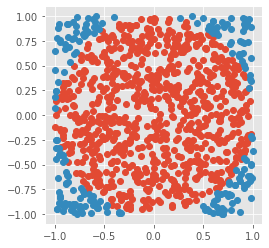

In [3]:
rndm = np.random.RandomState(12345)

N = 1000
x, y = rndm.uniform(low=-1, high=1, size=(2, N))
m = inside(x, y, 1)

fig, ax = plt.subplots()
ax.plot(x[m], y[m], 'o')
ax.plot(x[~m], y[~m], 'o')
ax.set_aspect('equal')


In [4]:
# Now, the estimate for the area is

4 * np.count_nonzero(m) / N

3.176

Note that the result comes as a sum of iid samples, so that the Central Limit Theorem says that the error of the estimate scales as $\propto 1 / \sqrt{N}$.

## II. Integrals of arbitrary functions

To generalize the prescription, let's rewrite it in a slightly more general form. Define 

$$
A(\mathbf{r}) = \left\{
\begin{aligned}
1,& \qquad{\mathbf{r} \in \mathcal{C}}\;, \\
0,& \qquad\text{otherwise}\;.
\end{aligned}
\right.
$$

Then the Buffon's needle prescription in $d$ dimensions is

$$
\frac{\int_\mathcal{D} A(\mathbf{r})\, d^d\mathbf{r}}{\Omega_D} \approx \frac{\sum_{j} A(\mathbf{r}_j)}{\sum_j 1} \;.
$$

Here $\mathbf{r}_j$ are $d$-dimensional vectors drawn from a uniform distribution on $\mathcal{D}$, the unit hypercube in $d$ dimensions.

When written in this form, the prescription is clearly valid for arbitrary $d$ and arbitrary functions $A(\mathbf{r})$.

#### Example: calculate

$$
\iint_\limits{x^2 + y^2 < 1}  e^{-(x^2 + y^2)} \, dx\, dy 
$$

Here $\mathcal{C}$ is the inside of a unit circle, $\{(x, y): x^2 + y^2 < 1 \}$, and $A(x, y) = e^{-(x^2+y^2)}$.

(This example is artificially fine-tuned to ease the comparison with an exact answer, which is $\pi (1 - e^{-1}).$)

In [5]:
def func(x, y):
    r2 = x**2 + y**2
    return np.exp(-r2)

In [29]:
def sample(N, r=1):
    N = int(N)
    x, y = rndm.uniform(low=-1, high=1, size=(2, N))
    accepted = inside(x, y, r)
    denom = accepted.sum()
    return np.sum(func(x[accepted], y[accepted]) / N) * 4, denom

In [30]:
sample(100)

(1.9561154816956656, 81)

In [31]:
answer = np.pi * (1. - 1./np.e)

np.random.seed(12)

for n in [100, 1000, 10000, 100000, 1e6, 1e7]:
    res = sample(n)
    err = res[0] - answer
    print("%8d  %.7g  %.7g %g" % (n, res[0], answer, err))

     100  1.922494  1.985865 -0.0633713
    1000  1.975477  1.985865 -0.0103882
   10000  1.990847  1.985865 0.00498175
  100000  1.986521  1.985865 0.000655431
 1000000  1.984057  1.985865 -0.00180873
10000000  1.985618  1.985865 -0.000247682


To improve convergence, we can either aim to sample the space *more* uniformly, or *less* uniformly.

## III. Quasi-random numbers: Sobol, Halton sequences

Instead of drawing random variates, use special *low-discrepancy sequences* which intend to cover the volume in a uniform manner.

Here's one implementation: In terminal, type 

`pip install sobol_seq --user`

In [9]:
import sobol_seq

In [10]:
sobol_seq.i4_sobol_generate?

In [11]:
sobol_seq.i4_sobol_generate(2, 5)

array([[0.5  , 0.5  ],
       [0.75 , 0.25 ],
       [0.25 , 0.75 ],
       [0.375, 0.375],
       [0.875, 0.875]])

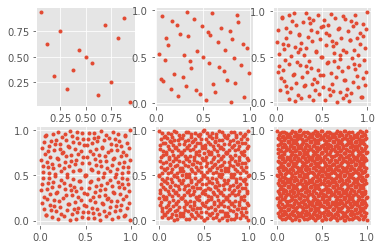

In [12]:
nn = [[15, 51, 151], [251, 521, 1001]]

fig, axx = plt.subplots(2, 3)

for i in (0, 1):
    for j in (0, 1, 2):
        N = nn[i][j]
        ax = axx[i][j]
        x = sobol_seq.i4_sobol_generate(2, N)
        ax.plot(x[:, 0], x[:, 1], 'o', label = "N = %s" % N, ms=4, mec='none')

## IV. Non-uniform distributions

If the integral has sharp peaks, both *Buffon needle II* and quasi-random based methods can be converging slowly.
If the integral is over an infinite range, they simply break down. 

Note that in *Buffon needle II*, the integral in the left-hand side contains the *probability density of a uniform distribution on $\mathcal{D}$*

$$
w_\mathrm{uniform}(\mathbf{r}) = \frac{1}{\Omega_D} d^d\mathbf{r}
$$

This suggests introducing a probability density $w(\mathbf{r})$, and rewriting the target integral via

$$
\int_\mathcal{D} A(\mathbf{r})\,d^d\mathbf{r} \equiv
\int_\mathcal{D} \frac{A(\mathbf{r}) }{ w(\mathbf{r})} \,\color{red}{w(\mathbf{r})\, d^d\mathbf{r}} \;.
$$

Now, if the sequence of $\{ \mathbf{r}_j\}$, $j=1, \dots, N$, *is drawn from the distribution $w(\mathbf{r})$*, then

$$
\int_\mathcal{D} A(\mathbf{r})\,d^d\mathbf{r} \approx \frac{\sum_j A(\mathbf{r}_j)\, /\, w(\mathbf{r}_j)}{\sum_j 1}
$$

#### Example

$$
\int_0^\infty \! x^3 e^{-x} \, dx = \text{?}
$$

Here we take $w(x) \propto e^{-x}$ on $x \in [0, \infty)$, and $A(x) = x^3$

In [13]:
for n in (1e4, 1e5, 1e6, 1e7):
    nn = int(n)
    x = np.random.exponential(size=nn)
    res = (x**3).sum() / n
    print("%8g  %.6g" % (nn, res))

   10000  6.12337
  100000  5.97928
   1e+06  6.00973
   1e+07  6.00365


### How to draw variates given a probability density function?

#### Rejection method

This is basically the Buffon's needle again: Given a p.d.f., $w(\mathbf{r})$, for $d$-dimensional variables, draw $d$ uniform variates, $\mathbf{r}$, and an extra one, $y$, uniform on $[0, 1)$. Compare $y$ and $w(\mathbf{r})$. If $y > w(\mathbf{r})$, *reject* it and draw again. Otherwise, return $\mathbf{r}$. 

#### Inversion method ($d=1$)

Draw $r$ uniform on  $[0, 1)$. Then invert the cumulative distribution function, `cdf`: find $x$ such that 

$$
\mathrm{cdf}(x) = r\;.
$$ 


##### Example

Draw variates from the standard exponential distribution $w(x) \propto \exp(-\lambda x)$ for $x \in [0, \infty)$.

Doing the integrals, we find

$$
\mathrm{cdf}(x) = A \int_0^x\! e^{-\lambda x }\, dx = A \frac{1 - e^{-\lambda x}}{\lambda} \;,
$$

where $A$ is the normalization constant, for which we find $A = \lambda$ since $\mathrm{cdf}(\infty) = 1$.

This way, we find 

$$
x = -\frac{1}{\lambda} \ln(1 - r) \;.
$$

Note that, strictly speaking, we cannot replace $1 - r$ by $r$ since that would be problematic at $r=0$.

(array([0.99693274, 0.96392172, 0.97712613, 0.99693274, 1.06735624,
        0.93971364, 0.91330483, 0.95511878, 1.09376506, 1.03434523,
        1.01894008, 1.02114082, 0.9881298 , 1.0453489 , 0.99033053,
        0.96612245, 0.97932686, 0.97712613, 0.99693274, 1.01453861,
        1.08276138, 0.9881298 ]),
 array([2.55561958e-04, 4.56949364e-02, 9.11343109e-02, 1.36573685e-01,
        1.82013060e-01, 2.27452434e-01, 2.72891809e-01, 3.18331183e-01,
        3.63770558e-01, 4.09209932e-01, 4.54649307e-01, 5.00088681e-01,
        5.45528055e-01, 5.90967430e-01, 6.36406804e-01, 6.81846179e-01,
        7.27285553e-01, 7.72724928e-01, 8.18164302e-01, 8.63603677e-01,
        9.09043051e-01, 9.54482426e-01, 9.99921800e-01]),
 <a list of 22 Patch objects>)

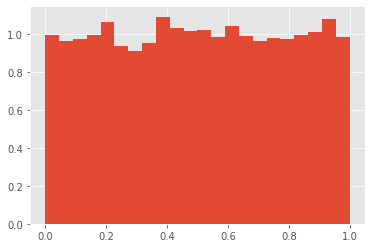

In [25]:
r = np.random.uniform(size=10000)
plt.hist(r, bins='auto', density=True)

(0, 3)

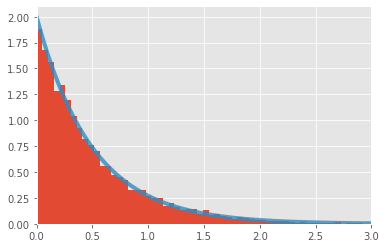

In [26]:
x = -0.5 * np.log(1 - r)
plt.hist(x, bins='auto', density=True)

xx = np.linspace(x.min(), x.max(), 101)
plt.plot(xx, 2.0 * np.exp(-2*xx), '-', lw=4, alpha=0.8)

plt.xlim([0, 3])

# Excercises

### Excercise 1

Use the Sobol sequence to calculate the value of
$$
\iint\limits_D e^{-(x^2 + y^2)} \, dx\, dy  \;,
$$
where $D$ is the unit square. Compare to the exact answer (which can be expressed in terms of the error function).

In [16]:
from scipy import integrate # exact value for the integral
f = lambda y, x: np.exp(-(x**2 +y**2))
result = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1)
answer = result[0]

In [17]:
import sobol_seq
def inside_sqr(x, y, r):
    return 0 < x < r and  0 < y < r

In [18]:
def sampling(N, r=1):
    N = int(N)
    z = sobol_seq.i4_sobol_generate(2, N)
    x = z[:, 0]
    y = z[:, 1]
    accepted = np.array([inside_sqr(i, j,1) for i, j in zip(x, y)]) 
    denom = accepted.sum()
    return np.sum(func(x[accepted], y[accepted]) / N) , denom

In [28]:
n = 1e7
res = sampling(n,1)
err = res[0] - answer
print(' при 𝑁=10^7 : ',err )

 при 𝑁=10^7 :  9.732271499807155e-08


Paste the difference between the exact answer and calculated value of the integral in the respective field in Google Form when $N = 10^7$.

### Excercise 2

Generate variates from the distribution $w(x) \propto \sqrt{1 - x^2}$ on $x\in (-1, 1)$ using the rejection method.

In [ ]:
def w(x):
    return np.sqrt(1 - x ** 2)

In [35]:
def rej(n):
    x = np.random.uniform(-1,1,n)
    y = np.random.uniform(-1,1,n)
    f = y[y < w(x)]
    return f

(array([0.55999979, 0.55686956, 0.56056892, 0.55992218, 0.5577362 ,
        0.55783967, 0.56342751, 0.55608054, 0.56337577, 0.56512197,
        0.56303947, 0.56492795, 0.55804663, 0.56200468, 0.56115099,
        0.56197881, 0.55983164, 0.5633111 , 0.56249621, 0.55979283,
        0.55918489, 0.56080175, 0.55434727, 0.56627317, 0.55985751,
        0.55716706, 0.5610087 , 0.55829239, 0.56108631, 0.55736109,
        0.5592237 , 0.56768307, 0.55895207, 0.55910729, 0.56082762,
        0.55558902, 0.56408719, 0.56181066, 0.55733522, 0.55631337,
        0.55953413, 0.55724467, 0.55974109, 0.56473393, 0.55512336,
        0.5577362 , 0.56244447, 0.55914609, 0.56015501, 0.56170718,
        0.56178479, 0.56143555, 0.56491502, 0.55755511, 0.56292306,
        0.56169425, 0.56042664, 0.56582045, 0.55870631, 0.56046544,
        0.55379108, 0.55659793, 0.56021968, 0.5621211 , 0.56142262,
        0.56408719, 0.55868044, 0.56144849, 0.55715413, 0.56362154,
        0.56103457, 0.55997392, 0.55626163, 0.55

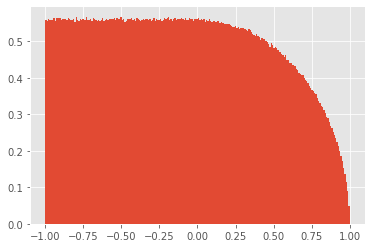

In [52]:
plt.hist(rej(int(1e7)), bins='auto', density=True)

Write a function for finding $\int_{-1}^1 \! \sqrt{1-x^2} \left( 1 - x \right) dx$.

In [56]:
for n in (100, 100000, 1000000, 10000000):
    nn = int(n)
    x = rej(n)
    res = (1 - x).sum() / n
    print("%8g  %.6g" % (nn, res))

     100  1.07291
  100000  0.975416
   1e+06  0.9754
   1e+07  0.976453


Paste the value of the integral in the respective field in Google Form when $N = 10^7$.

### Excercise 3

Generate variates from the distribution $w(x) \propto \exp(-\lambda x)$ on $x \in [a, b]$.

In [59]:
def find_var(lmbda, n):
    r = np.random.uniform(size=n)
    if lmbda != 0:
        x = (-1 * np.log(1 - r)) / lmbda
    return x

(array([9.94213726e-01, 9.80001419e-01, 9.77685048e-01, ...,
        0.00000000e+00, 0.00000000e+00, 9.81512949e-06]),
 array([4.90523086e-08, 1.01884016e-02, 2.03767542e-02, ...,
        1.67088983e+01, 1.67190867e+01, 1.67292750e+01]),
 <a list of 1642 Patch objects>)

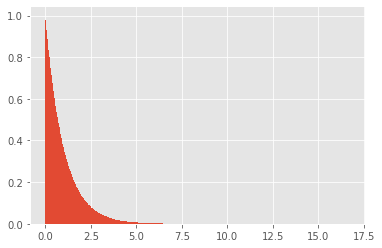

In [63]:
plt.hist(find_var(1,int(1e7)), bins='auto', density=True)

Write a function for finding $\int_0^\infty \! x^3 e^{- \lambda x}$.

In [65]:
l = 1
for n in (100, 100000, 1000000, 10000000):
    nn = int(n)
    x = find_var(l, nn)
    res = (x ** 3).sum() / n
    print("%8g  %.6g" % (nn, res))

     100  5.09648
  100000  5.8993
   1e+06  5.97859
   1e+07  6.00274


Paste the value of the integral in the respective field in Google Form when $N = 10^7$ and $\lambda = 5$.